# Why warp? A brief introduction to psychoacoustics

>It is well known that an allpass filter has unity gain at all frequencies. It is, therefore, frequently used in situations where a frequency-dependent phase shift is desirable, without imparting any gain or attenuation. ([1])

So far we've seen plots of the frequency response of the all-pass filter, and have verified the above statement. What situations would require a frequency-dependent phase shift? For this, we turn to psychoacoustics.

## Psychoacoustics

According to Wikipedia ([2]):

>Psychoacoustics is the scientific study of sound perception and audiology—how humans perceive various sounds. More specifically, it is the branch of science studying the psychological and physiological responses associated with sound (including noise, speech and music).

Many of the warped linear prediction-related papers I ready while preparing these materials mention the justification for why WLP is an interesting method.

>Warped linear predictive coding, WLPC, is a clear step forward in the utilization of characteristics of human hearing in designing coding algorithms since a WLPC system can be adjusted so that the spectral resolution closely approximates the frequency resolution of human hearing. ([3])

>Frequency-warped signal processing techniques are attractive to many wideband speech and audio applications since they have a clear connection to the frequency resolution of human hearing. A warped version of linear predictive coding is studied in this paper. The results indicate that the  use of warped techniques is beneficial especially in wideband coding and may result in savings of one bit per sample compared to the conventional algorithm while retaining the same subjective quality. ([3])

Since we specifically coded a cascaded first-order all-pass filters in the previous section to create a higher-order WFIR filter, this excerpt creates a direct connection to the Bark scale:

>The idea of the warped FFT was then applied to warped linear prediction (WLP) by Strube [4]. In his study a cascaded first order allpass network produces the frequency warping corresponding to the auditory Bark scale. ([5])

To sum up (and hopefully I'm not taking too many liberties here), we're interested in WLP techniques because:

1. Human hearing favors certain frequencies over others
2. When analyzing speech or music with DSP techniques, we could emphasize those human ear frequencies
3. The resulting models are closer to approximating how a human would perceive sound

It feels needless to say - but I'll say anyway - that making digital models for audio analysis or music information retrieval more closely resemble human hearing is an important step in HCI.

## The Bark scale

The Bark scale is one of the frequency scales that more accurately matches human hearing ([6], [7]). There is an expression for the warp factor which makes an all-pass filter behave like the Bark scale ([3], [8]):

$$\lambda_{f_{s}} \approx 1.0674 \sqrt{\frac{2}{\pi} arctan \left( \frac{0.06583f_{s}}{1000} \right)} - 0.1916$$

In [1]:
import numpy, scipy, scipy.signal

def bark_warp_coef(fs):
    return 1.0674 * numpy.sqrt((2.0 / numpy.pi) * numpy.arctan(0.06583 * fs / 1000.0)) - 0.1916

# some typical fs values:
print(bark_warp_coef(16000))
print(bark_warp_coef(22050))
print(bark_warp_coef(44100))
print(bark_warp_coef(48000))

0.5755300399316639
0.6461283841241534
0.7564135232844136
0.7660170004831646


## Remez filter coefficients

One of the last steps in the WFIR design proposed in [9] is generating filter coefficients with the Parks-McClellan remez algorithm ([10]).

In [2]:
def remez_coefs(a, order, fs):
    def warpingphase(w, a, fs):
        theta = numpy.angle(a)
        r = numpy.abs(a)
        wy = -w - 2 * numpy.arctan((r * numpy.sin(w - theta)) / (1 - r * numpy.cos(w - theta)))
        return wy

    fcw = -warpingphase(0.05 * numpy.pi, a, fs)
    fcny = fcw / numpy.pi
    band = [fcny / 2.0, fcny / 2.0 + 0.1]
    c = scipy.signal.remez(order + 1, [0,  band[0], band[1], 0.5], [1, 0], [1, 100])
    return c

fs = 48000
a = bark_warp_coef(fs)
order = 3

print(remez_coefs(a, order, fs))

[0.01659261 0.02809972 0.02809972 0.01659261]


[9], [11] propose the definitions of the `warpingphase()` function, and the parameters to the remez function. The arguments to `scipy.signal.remez` are:

`scipy.signal.remez(numtaps, bands, desired, weight=None, ...`

* numtaps: The desired number of taps in the filter. The number of taps is the number of terms in the filter, or the filter order plus one.

Easy enough to understand.

* bands: A monotonic sequence containing the band edges. All elements must be non-negative and less than half the sampling frequency as given by fs.

This is where all the interesting values (warpingphase, fcny, etc.) make their appearance. Some of the scipy documentation ([10]) examples have the following argument for bands:

```[0, cutoff, cutoff + trans_width, 0.5*fs]```

Compare this to what we have in our code:

```[0, fcny / 2.0, fcny / 2.0 + 0.1, 0.5]```

Our frequencies are normalized in terms of π rads/sample i.e. the normalized Nyquist frequency (fs / 2 = fNyquist), which can explain `0.5*fs` vs. `0.5`.

* desired: A sequence half the size of bands containing the desired gain in each of the specified bands.

* weight: A relative weighting to give to each band region. The length of weight has to be half the length of bands.

For these parameters, the author of [9], [11] discusses their choices based on their goal to create a low-pass filter - recall that we're trying to create an all-pass filter. If we re-plot the frequency response, we should see that it no longer has the properties of the all-pass filter.

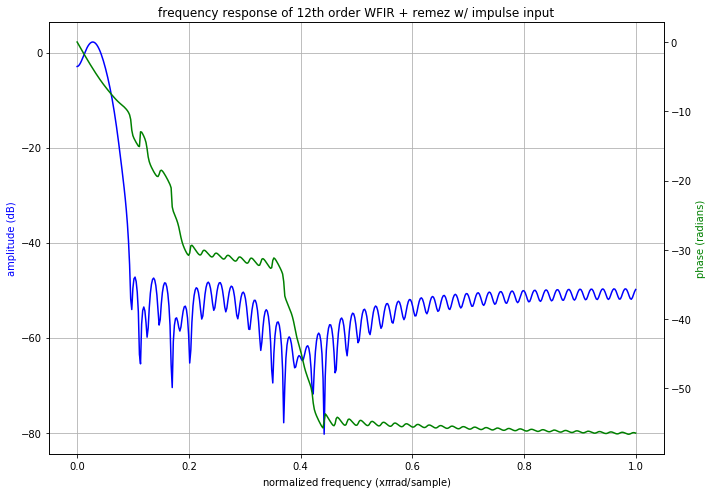

In [12]:
def wfir_remez(x: numpy.ndarray, fs: float, order: int) -> numpy.ndarray:
    a = bark_warp_coef(fs)
    c = remez_coefs(a, order, fs)

    B = [-a.conjugate(), 1]
    A = [1, -a]

    ys = [0] * order

    ys[0] = scipy.signal.lfilter(B, A, x)
    for i in range(1, len(ys)):
        ys[i] = scipy.signal.lfilter(B, A, ys[i - 1])

    yout = c[0] * x
    for i in range(order):
        yout += c[i+1] * ys[i]
        
    return yout

import matplotlib.pyplot as plt

l = 100
impulse = numpy.zeros(l); impulse[0] = 1.0
impulse_response = wfir_remez(impulse, 48000, 12)
w, h = scipy.signal.freqz(impulse_response, 1)

fig, ax11 = plt.subplots(figsize=(10, 7))
plt.title('frequency response of 12th order WFIR + remez w/ impulse input')
plt.plot(w/max(w), 20 * numpy.log10(abs(h)), 'b')
plt.ylabel('amplitude (dB)', color='b')
plt.xlabel(r'normalized frequency (x$\pi$rad/sample)')
ax11.grid()
ax21 = ax11.twinx()
angles = numpy.unwrap(numpy.angle(h))
plt.plot(w/max(w), angles, 'g')
plt.ylabel('phase (radians)', color='g')
plt.axis('tight')

fig.tight_layout()
plt.show()

**Not great!** By blindly copy-pasting the remez coefficient code, I turned a warping all-pass filter into a low-pass filter because I wasn't paying attention. Let's remove it and verify that we're back to having a flat frequency response.

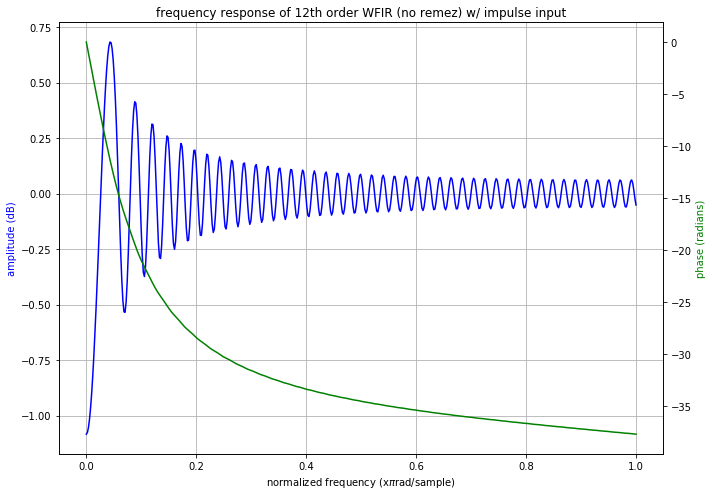

In [11]:
def wfir_noremez(x: numpy.ndarray, fs: float, order: int) -> numpy.ndarray:
    a = bark_warp_coef(fs)

    B = [-a.conjugate(), 1]
    A = [1, -a]

    ys = [0] * order

    ys[0] = scipy.signal.lfilter(B, A, x)
    for i in range(1, len(ys)):
        ys[i] = scipy.signal.lfilter(B, A, ys[i - 1])
        
    return ys[-1]

l = 100
impulse = numpy.zeros(l); impulse[0] = 1.0
impulse_response = wfir_noremez(impulse, 48000, 12)
w, h = scipy.signal.freqz(impulse_response, 1)

fig, ax11 = plt.subplots(figsize=(10, 7))
plt.title('frequency response of 12th order WFIR (no remez) w/ impulse input')
plt.plot(w/max(w), 20 * numpy.log10(abs(h)), 'b')
plt.ylabel('amplitude (dB)', color='b')
plt.xlabel(r'normalized frequency (x$\pi$rad/sample)')
ax11.grid()
ax21 = ax11.twinx()
angles = numpy.unwrap(numpy.angle(h))
plt.plot(w/max(w), angles, 'g')
plt.ylabel('phase (radians)', color='g')
plt.axis('tight')

fig.tight_layout()
plt.show()

There's no more -80dB attenuation, which is good.

In the next section, I'll have listening tests and audio clips of sine waves, speech, and music so we can start understanding intuitively what's happening inside this WFIR.

## References

1. Surges, Greg & Smyth, Tamara. (2013). "Spectral Distortion Using Second-Order Allpass Filters"

2. Wikipedia.org, "Psychoacoustics," https://en.wikipedia.org/wiki/Psychoacoustics

3. Harma A, Laine U. K., "A comparison of warped and conventional linear predictive coding," EDICS

4. Strube H. W., "Linear prediction on a warped frequency scale,", J. Acoust. Soc. Am., 64 (4), pp. 1071-1076, Oct. 1980

5. Kruger E, Strube H. W., "Linear prediction on a warped frequency scale," IEEE Tr. on Acoustics, Speech, and Signal Processing, 36 (9), pp. 1529-1531, Sept 1988

6. Smith, J.O. "Hamming Window," in Spectral Audio Signal Processing, https://ccrma.stanford.edu/~jos/sasp/Bark_Frequency_Scale.html, online book, 2011 edition, accessed 2019

7. Siemens Testing Knowledge Base, "Critical Bands in Human Hearing," https://community.plm.automation.siemens.com/t5/Testing-Knowledge-Base/Critical-Bands-in-Human-Hearing/ta-p/416798, 2017, accessed 2019

8. Härmä, Aki & Karjalainen, Matti & Avioja, Lauri & Välimäki, Vesa & Laine, Unto & Huopaniemi, Jyri. (2000). "Frequency-Warped Signal Processing for Audio Applications," Journal of the Audio Engineering Society. 48. 1011-1031.

9. Schuller G., "Frequency Warping, Example,", Digital Signal Processing 2/ Advanced Digital Signal Processing Lecture 10, TU-Ilmenau

10. SciPy documentation, "scipy.signal.remez," https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.remez.html

11. Schuller G., "Allpass Filters,", Digital Signal Processing 2/ Advanced Digital Signal Processing Lecture 9, TU-Ilmenau